In [1]:
#Load data into pandas and display information on variables

import pandas as pd

credit = pd.read_csv("creditcard.csv")

credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
#Check for NaNs
len(credit) - credit.count()

level_0    0
index      0
Time       0
V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
Amount     0
Class      0
dtype: int64

In [2]:
fraud = credit.drop("Class", axis=1)
fraud_labels = credit["Class"].copy()

In [3]:
X_train, X_test, y_train, y_test = fraud[:200000], fraud[200000:], fraud_labels[:200000], fraud_labels[200000:]

In [4]:
#always use .loc for assignment
import numpy as np
shuffle_index = np.random.permutation(200000)
X_train, y_train = X_train.loc[shuffle_index], y_train.loc[shuffle_index]

In [14]:
#MODEL 1 - Use Stochastic Gradient Descent for binary classification
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 2000, random_state = 23)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=2000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=23, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
from sklearn.metrics import confusion_matrix

y_pred_test = sgd_clf.predict(X_test)
confusion_matrix(y_test, y_pred_test)

array([[84700,     0],
       [  107,     0]], dtype=int64)

In [88]:
#A staggering 0 precision!
#Try using cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=23)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds1 = X_train.loc[train_index]
    y_train_folds1 = y_train.loc[train_index]
    X_test_fold1 = X_train.loc[test_index]
    y_test_fold1 = y_train.loc[test_index]
    
    clone_clf.fit(X_train_folds1, y_train_folds1)
    y_pred1 = clone_clf.predict(X_test_fold1)
    n_correct = sum(y_pred1 == y_test_fold1)
    print(n_correct/len(y_pred1))

0.99445011099778
0.9986049860498605
0.9982149821498215


In [80]:
confusion_matrix(y_test_fold1, y_pred1)

array([[66543,     0],
       [  119,     4]], dtype=int64)

In [101]:
#See if model improves by raising the threshold...
#Compute all decision scores using cross validation in training set
from sklearn.model_selection import cross_val_predict

y_scores1 = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method = "decision_function")

In [102]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores1)

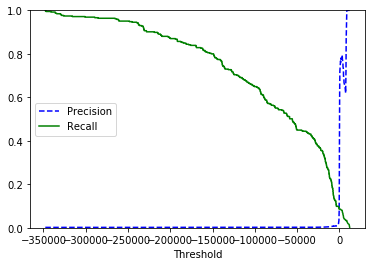

In [105]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

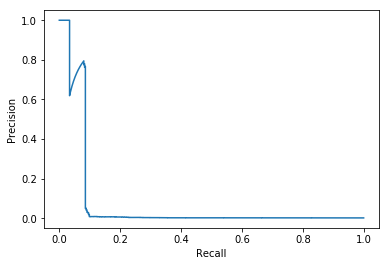

In [106]:
#Changing threshold past zero will not yield any benefits in this model
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [107]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores1)

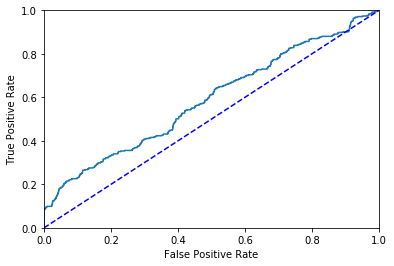

In [108]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'b--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr,tpr)
plt.show()

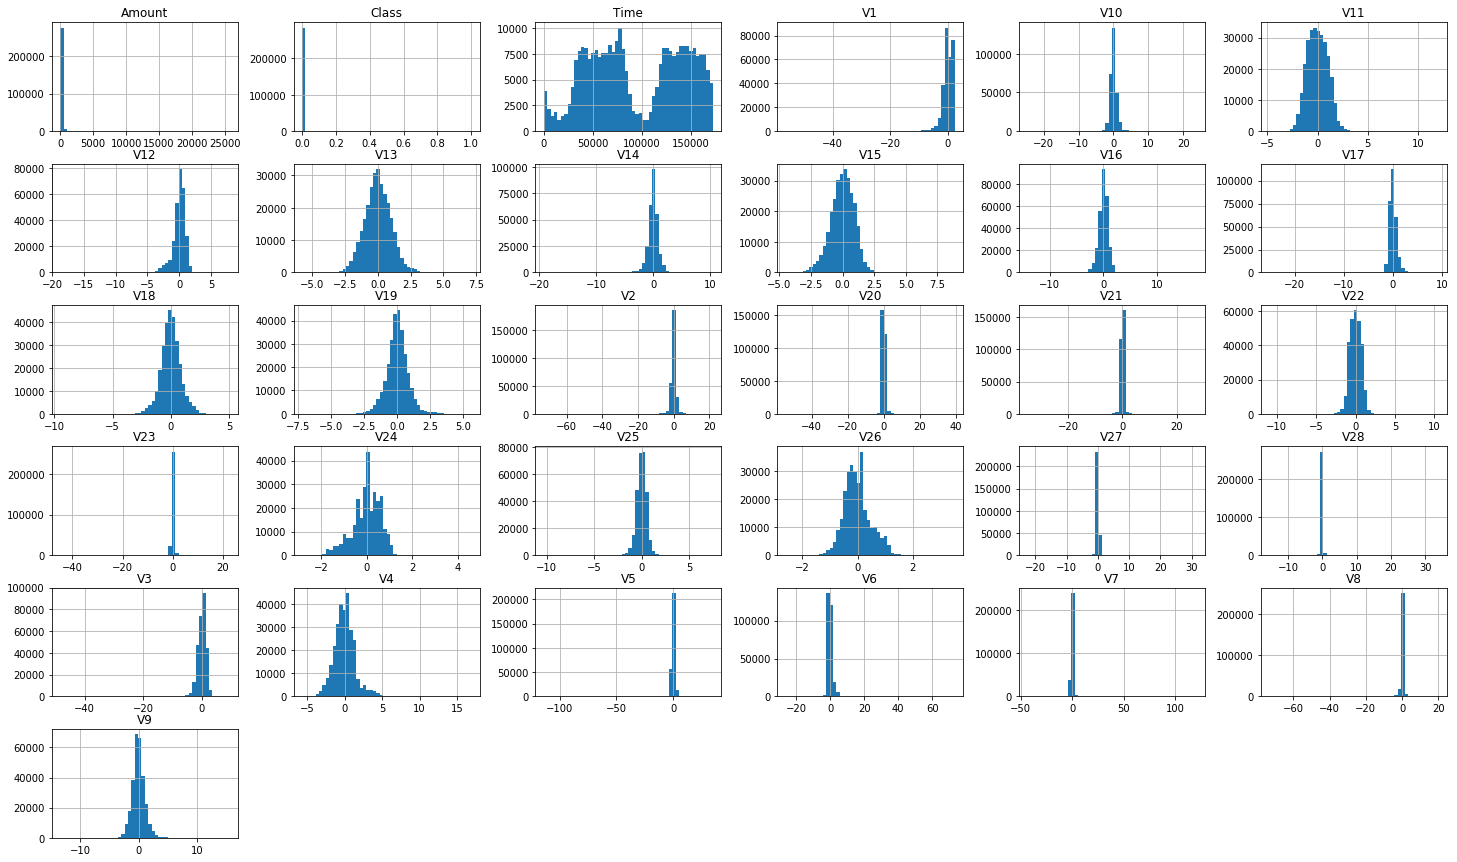

In [27]:
#Very poor model lift 
#The data appears to not benefit from cross validation together with stochastic gradient descent
#Next, we will try naive bayes classification, which though a simple model, is known to perform just as well as even the most complex classification algorithms

#Check to see if data appears to be Gaussian
%matplotlib inline
import matplotlib.pyplot as plt
credit.hist(bins=50, figsize=(25,15))
plt.show()

In [ ]:
#MODEL 2 - GUASSIAN NAIVE BAYES CLASSIFICATION

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0],(y_test != y_pred).sum()))

Number of mislabeled points out of a total 200000 points : 825


In [82]:
confusion_matrix(y_test, y_pred)



array([[83914,   786],
       [   39,    68]], dtype=int64)

In [83]:
#See if stratified sampling improves the model
skfolds = StratifiedKFold(n_splits = 3, random_state=23)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_gnb = clone(gnb)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train.loc[test_index]
    
    clone_gnb.fit(X_train_folds, y_train_folds)
    y_pred = clone_gnb.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9860652786944261
0.9935349353493534
0.985749857498575


In [85]:
confusion_matrix(y_test_fold, y_pred)

array([[65610,   933],
       [   17,   106]], dtype=int64)

In [86]:
#Very high precision, but low f1 score

rom sklearn.metrics import f1_score
f1_score(y_test_fold, y_pred)

0.18244406196213425

In [5]:
#Since there is a relatively small amount of data, perhaps using support vector machine classification is appropriate
#CHECK IF WE CAN EFFECTIVELY GET LINEAR SEPARATION IN THE DATA
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = Pipeline([("Scaler", StandardScaler()), ("linear_svc", LinearSVC(C=1, loss="hinge"))])
svm_clf.fit(X_train, y_train)

c:\users\dougm_000\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\dougm_000\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [6]:
y_pred3 = svm_clf.predict(X_test)

c:\users\dougm_000\appdata\local\programs\python\python37\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


c:\users\dougm_000\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\dougm_000\appdata\local\programs\python\python37\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


NameError: name 'X' is not defined

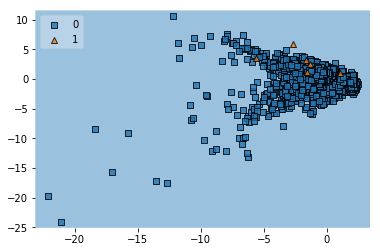

In [29]:
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Randomly sample 500 elements from the training dataset

X_hat = X_train.reset_index()
y_hat = y_train.reset_index()

X_tilde = X_hat.merge(y_hat, left_on='index', right_on='index', how='inner')

X_sample = X_tilde.sample(n=5000, random_state=23)

X_trsample = X_sample.drop("index", axis=1)
X_trsample = X_trsample.drop("Class", axis=1)
y_trsample = X_sample["Class"]
X_trsample1 = X_trsample[['V1', 'V2']]
# Fit Support Vector Machine Classifier

clf = svm.SVC(decision_function_shape='ovo', random_state=23)
clf.fit(X_trsample1.values, y_trsample.values) 



# Plot Decision Region using mlxtend's plotting function
plot_decision_regions(X=X_trsample1.values, 
                      y=y_trsample.values,
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary with variables V1 & V2', size=16)
